# Leadangle_model.ipynb

プラズマシートのパラメータに対してリード角の変動をみる。

In [1]:
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [2]:
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v / vmax, c))
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

whiteblue=generate_cmap(['#000000','#010E5E','#042AA6','#0F7CE0','#1AC7FF','#FFFFFF'])

In [3]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [4]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [5]:
# 定数
r_orbitM = 9.38*RJ   # ORBITAL RADIUS (average) [m] (Bagenal+2015)
r_orbitC = 9.30*RJ   # ORBITAL RADIUS (closest) [m] (Bagenal+2015)
r_orbitF = 9.47*RJ   # ORBITAL RADIUS (farthest) [m] (Bagenal+2015)
MOONRADI = 1.56E+6   # MOON RADIUS [m]
OMG_E = 2.0478E-5    # 衛星の公転角速度 [rad/s]
n0 = 110             # [cm-3] (Cassidy+2013)

ne_1 = 63            # 電子数密度 [cm-3] (Bagenal+2015)
ne_2 = 158           # 電子数密度 [cm-3] (Bagenal+2015)
ne_3 = 290           # 電子数密度 [cm-3] (Bagenal+2015)

Ai = 18              # 平均イオン原子量 (Bagenal+2015)
Zi = 1.4             # 平均イオン価数 [q] (Bagenal+2015)

Ti_14 = 68           # 平均イオン温度 [eV] (Best fit 2014_6)
rho0_14 = 1862       # プラズマ質量密度 [amu cm-3] (Best fit 2014_6)

Ti_22 = 138          # 平均イオン温度 [eV] (Best fit 2022_6)
rho0_22 = 2684       # プラズマ質量密度 [amu cm-3] (Best fit 2022_6)

Ti_14 = 74           # 平均イオン温度 [eV] (Best fit 2014_7)
rho0_14 = 1686       # プラズマ質量密度 [amu cm-3] (Best fit 2014_7)

Ti_22 = 134          # 平均イオン温度 [eV] (Best fit 2022_7)
rho0_22 = 2801       # プラズマ質量密度 [amu cm-3] (Best fit 2022_7)

H_p = 1.8*RJ         # [m]
Hp0 = 0.64*RJ        # 基準スケールハイト [m] (Bagenal&Delamere2011)
wlonN = copy.copy(satovalN.wlon)
FwlonN = copy.copy(satovalN.euwlon)
FlatN = copy.copy(satovalN.eulat)
FwlonS = copy.copy(satovalS.euwlon)
FlatS = copy.copy(satovalS.eulat)

OMGR = OMGJ-OMG_E

In [6]:
# Plasma sheet scale height
Hp_14 = Hp0*math.sqrt(Ti_14/Ai)     # Scale height [m] (Bagenal&Delamere2011)
Hp_22 = Hp0*math.sqrt(Ti_22/Ai)     # Scale height [m] (Bagenal&Delamere2011)

In [7]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 50))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta = 0.5*np.pi-S3lat
phi = 2*np.pi-S3wlon
B = np.zeros(phi.shape)
# Br = np.zeros(phi.shape)
# Btheta = np.zeros(phi.shape)
B_far = np.zeros(phi.shape)
B_close = np.zeros(phi.shape)
for i in range(phi.size):
    x = r_orbitM*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitM*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitM*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitM, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitC*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitC*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitC*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitC, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_close[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitF*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitF*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitF*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitF, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_far[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

In [8]:
# 衛星のトーラス内相対位置
# S3RH座標系の(x, y, z)座標
x0 = r_orbitM*np.cos(phi)
y0 = r_orbitM*np.sin(phi)
z0 = np.zeros(x0.shape)
rvec0 = np.array([x0, y0, z0])

# S3RH で Z軸 の(右ネジ)まわりに-65.8度回転
phiRH0 = math.radians(-65.8)    # Connerney+2020
rvec0 = np.array([
    rvec0[0, :]*math.cos(phiRH0) - rvec0[1, :]*math.sin(phiRH0),
    rvec0[0, :]*math.sin(phiRH0) + rvec0[1, :]*math.cos(phiRH0),
    rvec0[2, :]
])

# S3RH で X軸 の(右ネジ)まわりに-7度回転 -> 遠心力座標系に
TILT0 = math.radians(6.7)
rvec = np.array([
    rvec0[0, :],
    rvec0[1, :]*math.cos(TILT0) - rvec0[2, :]*math.sin(TILT0),
    rvec0[1, :]*math.sin(TILT0) + rvec0[2, :]*math.cos(TILT0)
])

# 遠心力座標系における緯度を計算する
theta_cent = np.arccos(rvec[2, :]/r_orbitM)     # 余緯度 [rad]
lat_cent = np.degrees(0.5*np.pi-theta_cent)     # 緯度 [deg]

In [9]:
# %% Rho, VA, and Lead angle (North)

# 2014
tau = np.zeros(S3wlon.size)
rho_1 = np.zeros(S3wlon.size)
VA_1 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_14, Hp_14, 'N')      # 北向きの伝搬
    rho_1[i] = rho0_14*AMU*1E+6*np.exp(-(S0/Hp_14)**2)
    VA_1[i] = B[i]/math.sqrt(MU0*rho_1[i])
leadangle_14 = np.degrees(OMGR*tau)
np.savetxt('bestfit14_N.txt', np.array([S3wlon, leadangle_14]))

# 2022
tau = np.zeros(S3wlon.size)
rho_1 = np.zeros(S3wlon.size)
VA_1 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_22, Hp_22, 'N')      # 北向きの伝搬
    rho_1[i] = rho0_22*AMU*1E+6*np.exp(-(S0/Hp_22)**2)
    VA_1[i] = B[i]/math.sqrt(MU0*rho_1[i])
leadangle_22 = np.degrees(OMGR*tau)
np.savetxt('bestfit22_N.txt', np.array([S3wlon, leadangle_22]))

In [10]:
# HST data
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

hem = 'North'

north_doy14 = ['14/006_v06', '14/013_v13', '14/016_v12']
north_doy22 = ['22/271_v18', '22/274_v17']
north_doy = north_doy14 + north_doy22
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 'N'
if hem == 'South':
    refnum = 'S'
satoval = np.recfromtxt('data/JRM33/satellite_foot_'+refnum+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

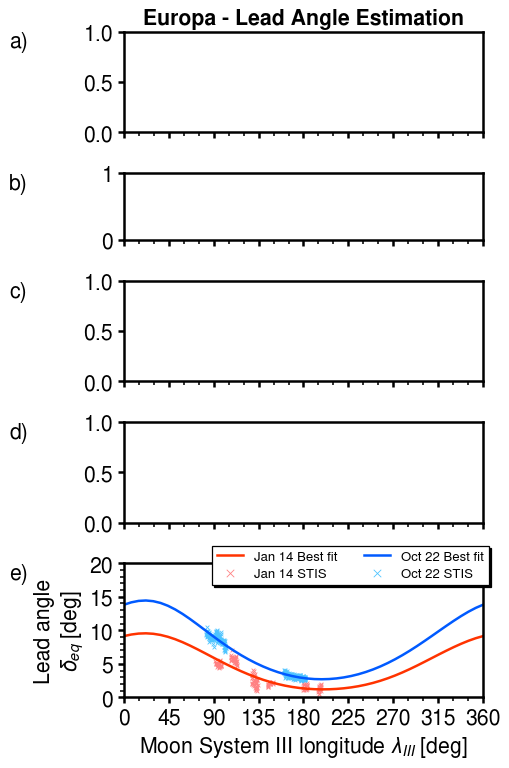

In [11]:
fsize = 17
fig, ax = plt.subplots(5, 1, figsize=(4.7, 8), dpi=90,
                       height_ratios=[3, 2, 3, 3, 4])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.32, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)


ax[0].set_title(MOON+' - Lead Angle Estimation', weight='bold', fontsize=fsize)

ax[4].set_ylim(0, 20)
ax[4].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[4].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[4].set_yticks(np.arange(0, 21, 5))
ax[4].set_yticklabels(np.arange(0, 21, 5))

# 2014
ax[4].plot(np.degrees(S3wlon), leadangle_14,
           linestyle='solid', linewidth=2, color=cud4[0],
           label='Jan 14 Best fit')
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    if i == 0:
        ax[4].scatter(moons30_arr, eq_leadangle, marker='x', s=9, c=cud4[5], label='Jan 14 STIS', linewidths=0.65, zorder=1)
    else:
        ax[4].scatter(moons30_arr, eq_leadangle, marker='x', s=9, c=cud4[5], linewidths=0.65, zorder=1)


# 2022
ax[4].plot(np.degrees(S3wlon), leadangle_22,
           linestyle='solid', linewidth=2, color=cud4[3],
           label='Oct 22 Best fit')
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    if i == 0:
        ax[4].scatter(moons30_arr, eq_leadangle, marker='x', s=9, c=cud4[4], label='Oct 22 STIS', linewidths=0.65, zorder=1)
    else:
        ax[4].scatter(moons30_arr, eq_leadangle, marker='x', s=9, c=cud4[4], linewidths=0.65, zorder=1)

ax[4].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

legend1 = ax[4].legend(loc='upper center',
                       ncol=2,
                       markerscale=2,
                    bbox_to_anchor=(0.63, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fsize*0.62,
                    labelspacing=0.34,)
# legend1.set_title('Jan 2014', prop={'size': fsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[4], legend1, dx=0.006, dy=-0.003)


plt.show()

# 南半球データにも重ねる

In [12]:
# 2022
tau = np.zeros(S3wlon.size)
rho_1 = np.zeros(S3wlon.size)
VA_1 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_14, Hp_14, 'S')      # 北向きの伝搬
    rho_1[i] = rho0_14*AMU*1E+6*np.exp(-(S0/Hp_14)**2)
    VA_1[i] = B[i]/math.sqrt(MU0*rho_1[i])
leadangle_14 = np.degrees(OMGR*tau)
np.savetxt('bestfit14_S.txt', np.array([S3wlon, leadangle_14]))

# 2022
tau = np.zeros(S3wlon.size)
rho_1 = np.zeros(S3wlon.size)
VA_1 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_22, Hp_22, 'S')      # 北向きの伝搬
    rho_1[i] = rho0_22*AMU*1E+6*np.exp(-(S0/Hp_22)**2)
    VA_1[i] = B[i]/math.sqrt(MU0*rho_1[i])
leadangle_22 = np.degrees(OMGR*tau)
np.savetxt('bestfit22_S.txt', np.array([S3wlon, leadangle_22]))

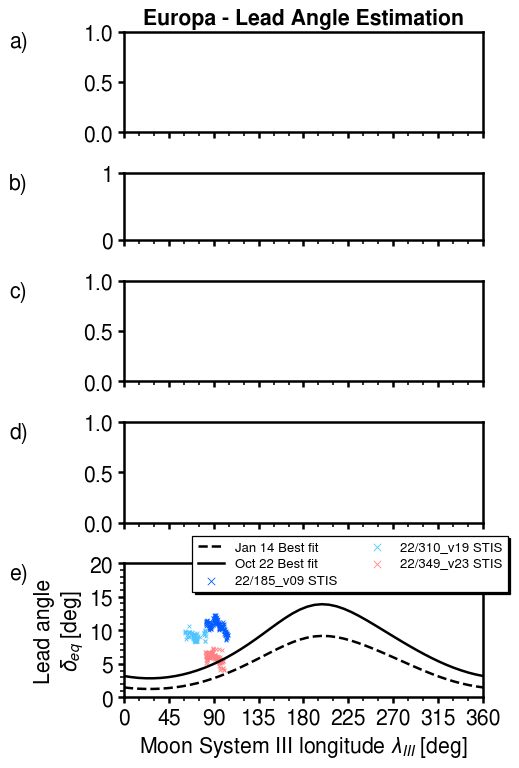

In [13]:
fsize = 17
fig, ax = plt.subplots(5, 1, figsize=(4.7, 8), dpi=90,
                       height_ratios=[3, 2, 3, 3, 4])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.32, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)


ax[0].set_title(MOON+' - Lead Angle Estimation', weight='bold', fontsize=fsize)

ax[4].set_ylim(0, 20)
ax[4].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[4].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[4].set_yticks(np.arange(0, 21, 5))
ax[4].set_yticklabels(np.arange(0, 21, 5))

# 2014
ax[4].plot(np.degrees(S3wlon), leadangle_14,
           linestyle='dashed', linewidth=2, color='k',
           label='Jan 14 Best fit')

# 2022
ax[4].plot(np.degrees(S3wlon), leadangle_22,
           linestyle='solid', linewidth=2, color='k',
           label='Oct 22 Best fit')
for i in range(len(south_doy)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+south_doy[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[4].scatter(moons30_arr, eq_leadangle, marker='x', s=9, c=cud4[i+3],
                  label=str(south_doy[i])+' STIS', linewidths=0.65, zorder=1)

ax[4].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

legend1 = ax[4].legend(loc='upper center',
                       ncol=2,
                       markerscale=2,
                    bbox_to_anchor=(0.63, 1.25),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fsize*0.62,
                    labelspacing=0.34,)
# legend1.set_title('Jan 2014', prop={'size': fsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[4], legend1, dx=0.006, dy=-0.003)


plt.show()

In [14]:
print(leadangle_22)

[ 3.1873118   3.01808245  2.90299156  2.84482908  2.84345306  2.89626532
  3.00670714  3.17274225  3.39642734  3.6776579   4.01648254  4.41095539
  4.86325868  5.36954444  5.9314881   6.54583916  7.21495963  7.92991818
  8.68665585  9.47415408 10.27546675 11.06510281 11.81887221 12.50083699
 13.07545222 13.51109069 13.78415735 13.8807104  13.80722851 13.57278817
 13.20590567 12.73071218 12.17589411 11.56535787 10.92243162 10.25966159
  9.59145809  8.92637491  8.27136667  7.63246197  7.01335596  6.41925497
  5.8586928   5.33418253  4.85284698  4.41547916  4.02866665  3.69267557
  3.41166677  3.1873118 ]
